In [1]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['figure.dpi'] = 90
plt.rcParams.update({'font.size': 12})

In [2]:
#define the shape of the environment (i.e., its states)
environment_rows = 10
environment_columns = 10

#Create a 3D numpy array to hold the current Q-values for each state and action pair: Q(s, a) 
#The array contains 10 rows and 10 columns (to match the shape of the environment), as well as a third "action" dimension.
#The "action" dimension consists of 4 layers that will allow us to keep track of the Q-values for each possible action in
#each state (see next cell for a description of possible actions). 
#The value of each (state, action) pair is initialized to 0.
q_values1 = np.zeros((environment_rows, environment_columns, 4))
q_values2 = np.zeros((environment_rows, environment_columns, 4))
q_values3 = np.zeros((environment_rows, environment_columns, 4))
q_values4 = np.zeros((environment_rows, environment_columns, 4))


In [3]:
#define actions
#numeric action codes: 0 = up, 1 = right, 2 = down, 3 = left
actions = ['up', 'right', 'down', 'left']

In [4]:
#Define the environment and its functions
class WSN():
  def __init__(self, Q = None):
    self.Q = Q
  
  #define a function that simulate the function of SDN and control the behaviour of nodes
  def get_reward(self,row, column):
    #Create a 2D numpy array to hold the rewards for each state. 
    #The array contains 10 rows and 10 columns (to match the shape of the environment), and each value is initialized to -1.
    rewards = np.full((environment_rows, environment_columns), -1.)
    rewards[9, 9] = 1. #set the reward for the destination node (i.e., the goal) to 1

    #define malicious node(8 nodes) locations for rows 0 through 9
    malicious = {} #store locations in a dictionary
    malicious[1] = [5]
    malicious[2] = [1]
    malicious[3] = [2]
    malicious[4] = [3]
    malicious[5] = [4]
    malicious[6] = [5]
    malicious[7] = [8]
    malicious[8] = [3]

    #set the rewards for all maicious node
    for row_index in range(1, 9):
      for column_index in malicious[row_index]: 
        rewards[row_index, column_index] = -2.
    
    return rewards[row, column]
  
  #define a function that determines if the specified location is a terminal state(either a malicious node or the destination node)
  def is_terminal_state(self, current_row_index, current_column_index):
    #if the reward for this location is -1, then it is not a terminal state
    if self.get_reward(current_row_index, current_column_index) == -1.:
      return False
    else:
      return True

  #define a function that will choose a random, non-terminal starting location
  def get_starting_location(self):
    #get a random row and column index
    current_row_index = np.random.randint(environment_rows)
    current_column_index = np.random.randint(environment_columns)
    #continue choosing random row and column indexes until a non-terminal state is identified
    #(i.e., until the chosen state is a 'normal node').
    while self.is_terminal_state(current_row_index, current_column_index):
      current_row_index = np.random.randint(environment_rows)
      current_column_index = np.random.randint(environment_columns)
    return current_row_index, current_column_index

  #define an epsilon greedy algorithm that will choose which action to take next
  def get_next_action(self, current_row_index, current_column_index, epsilon):
    if np.random.random() > epsilon:
      return np.argmax(self.Q[current_row_index, current_column_index])
    else: #choose a random action
      return np.random.randint(4)
  
  #define a function that will get the next location based on the chosen action
  def get_next_location(self, current_row_index, current_column_index, action_index):
    new_row_index = current_row_index
    new_column_index = current_column_index
    if actions[action_index] == 'up' and current_row_index > 0:
      new_row_index -= 1
    elif actions[action_index] == 'right' and current_column_index < environment_columns - 1:
      new_column_index += 1
    elif actions[action_index] == 'down' and current_row_index < environment_rows - 1:
      new_row_index += 1
    elif actions[action_index] == 'left' and current_column_index > 0:
      new_column_index -= 1
    return new_row_index, new_column_index



In [8]:
def Thesis_approach(epsilone = 0, discount_factor = 0.2, learning_rate = 0.9, a = 0.9):
    
    env = WSN(Q=q_values1)  #initialize the environmnet and the Q-table 
    
    packet_delivery = []    #the variable to store the rate of packet delivery in each episode
    t_energy = []           #the variable to store the amount of consumed energy for each episode
    alive = []              #the variable to sotre the number of alive nodes after each apisode

    path_lenght = 0        # the path that data pcket has gone through
    energy_per_node = 0.007    # the amount of energy(mJ) consumed by a node to receive and forward a packet
    nb_success = 0         #the number of successful data packet delivery     
    total_energy = 0        #the amount of conusmed energy for each episode
    active_mode = 0.0005    #the amount of energy(mj) cosumed by a node for being in active mode
    alive_node = 100        # Bumber of nodes in the network

    # define the initial energy of nodes
    initial_energy = np.full((environment_rows, environment_columns), 500.)

    #run through 1000 training episodes
    for episode in range(1000):
      #get the starting location for this episode
      row_index, column_index = env.get_starting_location()
  
      #initialize the consumed energy to zero for the current episode
      energy = 0 

      #continue taking actions (i.e., moving) until we reach a terminal state
      #(i.e., until the data packet reaches the destination node or gets stuck wiht a malicious node)
      while not env.is_terminal_state(row_index, column_index):
          #choose which action to take (i.e., where to move next)
          action_index = env.get_next_action(row_index, column_index, epsilone)

          #perform the chosen action, and transition to the next state (i.e., move to the next node)
          old_row_index, old_column_index = row_index, column_index #store the old row and column indexes
          row_index, column_index = env.get_next_location(row_index, column_index, action_index)
    
          #receive the reward from SDN for moving to the new state
          reward = env.get_reward(row_index, column_index)

          #calculate the distance to the destination node
          hop = 18-row_index-column_index
          #calculated the reward based on the reward function wiht regards to our two objectives
          R = a*reward - ((1-a)*(hop+1))
          # store the current Q-value for the previous state and action pair
          old_q_value = q_values1[old_row_index, old_column_index, action_index]
          #calculate the temporal differece
          temporal_difference = R + (discount_factor * np.max(q_values1[row_index, column_index])) - old_q_value

          #update the Q-value for the previous state and action pair
          new_q_value = old_q_value + (learning_rate * temporal_difference)
          q_values1[old_row_index, old_column_index, action_index] = new_q_value

          #calculate the current energy-level for both receiver and transmitter nodes
          initial_energy[row_index, column_index] -= active_mode
          initial_energy[old_row_index, old_column_index] = initial_energy[old_row_index, old_column_index] - energy_per_node - active_mode

          # if the energy level of a node is zero or less, it means that the node is died
          if initial_energy[row_index, column_index] <= 0:
              alive_node -= 1

          # If the data packet reaches the destination node, add one to the number of successful packet delivery
          if reward == 1:
              nb_success += 1

          # add one step to path lenght
          path_lenght += 1

      alive.append(alive_node)  # add the number of alive node to its list
      packet_delivery.append(nb_success/(episode+1))    #add the packet delivery rate to its list
      energy = path_lenght*energy_per_node + 2*path_lenght*active_mode      #calculate the total amount of energy cosumed in the episode
      total_energy += energy        #calculate the amount of total consumed energy
      t_energy.append(energy)       #add the amount of consumed energy to its list

    print('Training complete!')
    print('number of packet delivered:', nb_success)
    print("delivery rate: ", nb_success/episode)
    print("Energy : ", total_energy/episode)

    return(packet_delivery, t_energy, alive)


In [5]:
def Q_learning(epsilone = 0, discount_factor = 0.2, learning_rate = 0.9):
    
    env = WSN(Q=q_values2)
    
    packet_delivery = []    
    t_energy = []
    alive = []

    path_lenght = 0        
    energy_per_node = 0.007   
    nb_success = 0
    total_energy = 0 
    active_mode = 0.0005
    alive_node = 100

    # define the initial energy of nodes
    initial_energy = np.full((environment_rows, environment_columns), 500.)

    #run through 1000 training episodes
    for episode in range(1000):
      #get the starting location for this episode
      row_index, column_index = env.get_starting_location()
  
      #initialize the amount of consumed energy to zero for the curretn episode
      energy = 0

      #continue taking actions (i.e., moving) until we reach a terminal state
      #(i.e., until the data packet reaches the destination node or stuck wiht a malicious node)
      while not env.is_terminal_state(row_index, column_index):
          #choose which action to take (i.e., where to move next)
          action_index = env.get_next_action(row_index, column_index, epsilone)


          #perform the chosen action, and transition to the next state (i.e., move to the next node)
          old_row_index, old_column_index = row_index, column_index #store the old row and column indexes
          row_index, column_index = env.get_next_location(row_index, column_index, action_index)
    
          #receive the reward from SDN for moving to the new state
          reward = env.get_reward(row_index, column_index)
    
          old_q_value = q_values2[old_row_index, old_column_index, action_index]
          temporal_difference = reward + (discount_factor * np.max(q_values2[row_index, column_index])) - old_q_value

          #update the Q-value for the previous state and action pair
          new_q_value = old_q_value + (learning_rate * temporal_difference)
          q_values2[old_row_index, old_column_index, action_index] = new_q_value

          #calculate the current energy-level for all nodes
          initial_energy = initial_energy- active_mode
          initial_energy[old_row_index, old_column_index] -= energy_per_node

          #if the nergy level of a node is zero or less, it means that node is died
          if initial_energy[row_index, column_index] <= 0:
              alive_node -= 1

          # If we have a reward, it means that our outcome is a success
          if reward == 1:
              nb_success += 1

          # add one step to path lenght
          path_lenght += 1

      alive.append(alive_node)
      packet_delivery.append(nb_success/(episode+1))
      energy = path_lenght*energy_per_node + 100*path_lenght*active_mode
      total_energy += energy
      t_energy.append(energy)

    print('Training complete!')
    print('number of packet delivered:', nb_success)
    print("delivery rate: ", nb_success/episode)
    print("Energy : ", total_energy/episode)

    return(packet_delivery, t_energy, alive)


In [6]:
def R2LTO(epsilone = 0, discount_factor = 0.2, learning_rate = 0.9):
    
    env = WSN(Q= q_values3)
    
    packet_delivery = []
    t_energy = []
    alive = []

    path_lenght = 0        
    energy_per_node = 0.007    
    nb_success = 0
    total_energy = 0 
    #hop = 0
    active_mode = 0.0005
    alive_node = 100

    initial_energy = np.full((environment_rows, environment_columns), 500.)

    #run through 1000 training episodes
    for episode in range(1000):
        #get the starting location for this episode
      row_index, column_index = env.get_starting_location()
  
      #initialize the consumed energy to zero for the curretn episode
      energy = 0

      #continue taking actions (i.e., moving) until we reach a terminal state
      #(i.e., until we reach the item packaging area or crash into an item storage location)
      while not env.is_terminal_state(row_index, column_index):
          #choose which action to take (i.e., where to move next)
          action_index = env.get_next_action(row_index, column_index, epsilone)

          #perform the chosen action, and transition to the next state (i.e., move to the next location)
          old_row_index, old_column_index = row_index, column_index #store the old row and column indexes
          row_index, column_index = env.get_next_location(row_index, column_index, action_index)
    
          #calculate the reward for moving to the new state
          reward = env.get_reward(row_index, column_index)
          hop = 18-row_index-column_index
          R = initial_energy[row_index, column_index]/(hop+1)

    
          old_q_value = q_values3[old_row_index, old_column_index, action_index]
          temporal_difference = R + (discount_factor * np.max(q_values3[row_index, column_index])) - old_q_value

          #update the Q-value for the previous state and action pair
          new_q_value = old_q_value + (learning_rate * temporal_difference)
          q_values3[old_row_index, old_column_index, action_index] = new_q_value

          initial_energy -= active_mode
          initial_energy[old_row_index, old_column_index] -= energy_per_node

          if initial_energy[row_index, column_index] <= 0:
              alive_node -= 1

          # If we have a reward, it means that our outcome is a success
          if reward == 1:
              nb_success += 1
          
          # add one step to path lenght
          path_lenght += 1
      
      alive.append(alive_node)
      packet_delivery.append(nb_success/(episode+1))
      energy = path_lenght*energy_per_node + 100*path_lenght*active_mode
      total_energy += energy
      t_energy.append(energy)

    print('Training complete!')
    print('number of packet delivered:', nb_success)
    print("delivery rate: ", nb_success/episode)
    print("Energy : ", total_energy/episode)

    return(packet_delivery, t_energy, alive)


In [7]:
def RLBR(epsilone = 0, discount_factor = 0.2, learning_rate = 0.9):
    
    env = WSN(Q= q_values4)    
    
    packet_delivery = []        
    t_energy = []
    alive = []

    path_lenght = 0        
    energy_per_node = 0.007    
    nb_success = 0
    total_energy = 0 
    #hop = 0
    active_mode = 0.0005
    alive_node = 100

    initial_energy = np.full((environment_rows, environment_columns), 500.)

    #run through 1000 training episodes
    for episode in range(1000):
      #get the starting location for this episode
      row_index, column_index = env.get_starting_location()
  
      #initialize the consumed energy to zero for the current episode
      energy = 0

      #continue taking actions (i.e., moving) until we reach a terminal state
      #(i.e., until we reach the item packaging area or crash into an item storage location)
      while not env.is_terminal_state(row_index, column_index):
          #choose which action to take (i.e., where to move next)
          action_index = env.get_next_action(row_index, column_index, epsilone)

          #perform the chosen action, and transition to the next state (i.e., move to the next location)
          old_row_index, old_column_index = row_index, column_index #store the old row and column indexes
          row_index, column_index = env.get_next_location(row_index, column_index, action_index)
    
          #calculate the reward for moving to the new state
          hop = 18-row_index-column_index
          reward = env.get_reward(row_index, column_index)
          R = initial_energy[row_index, column_index]/(81*(hop+1))

    
          old_q_value = q_values4[old_row_index, old_column_index, action_index]
          temporal_difference = R + (discount_factor * np.max(q_values4[row_index, column_index])) - old_q_value

          #update the Q-value for the previous state and action pair
          new_q_value = old_q_value + (learning_rate * temporal_difference)
          q_values4[old_row_index, old_column_index, action_index] = new_q_value

          initial_energy -= active_mode
          initial_energy[old_row_index, old_column_index] -= energy_per_node

          if initial_energy[row_index, column_index] <= 0:
              alive_node -= 1

          if reward == 1:
              nb_success += 1

          # add one step to path lenght
          path_lenght += 1

      alive.append(alive_node)
      packet_delivery.append(nb_success/(episode+1))
      energy = path_lenght*energy_per_node + 100*path_lenght*active_mode
      total_energy += energy
      t_energy.append(energy)

    print('Training complete!')
    print('number of packet delivered:', nb_success)
    print("delivery rate: ", nb_success/episode)
    print("average Energy : ", total_energy/episode)

    return(packet_delivery, t_energy, alive)


In [9]:
# Experinmet 1 

packet_delivery , t_energy, alive_node = Thesis_approach()

Training complete!
number of packet delivered: 966
delivery rate:  0.9669669669669669
Energy :  40.50070070070072


In [10]:
packet_delivery2 , t_energy2, alive_node2 = Q_learning()

Training complete!
number of packet delivered: 968
delivery rate:  0.968968968968969
Energy :  404.57704204204214


In [11]:
delivery , energy, alive_node3 = R2LTO()

Training complete!
number of packet delivered: 11
delivery rate:  0.011011011011011011
Energy :  52917.38264564566


In [12]:
delivery2 , energy2, alive_node4 = RLBR()

Training complete!
number of packet delivered: 16
delivery rate:  0.016016016016016016
average Energy :  52921.4932642643


In [13]:
import pandas as pd

index_p = ['300','500','800','1000']
index_m = ['2', '4', '6', '8']

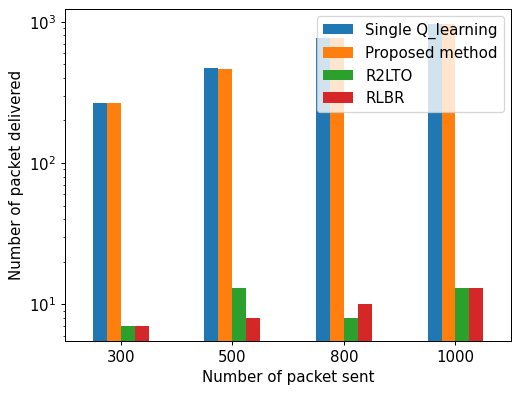

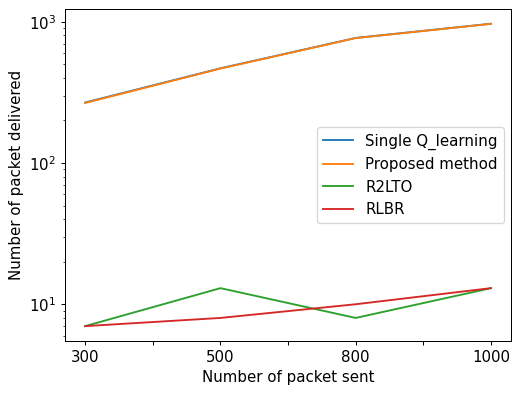

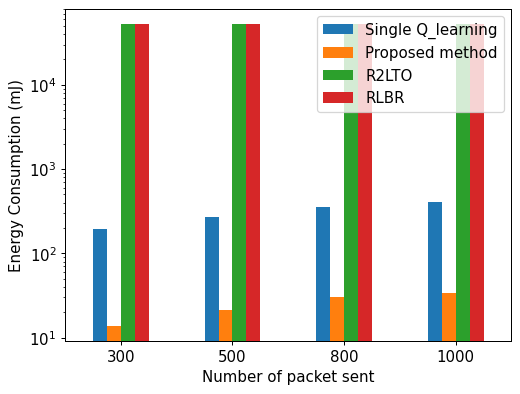

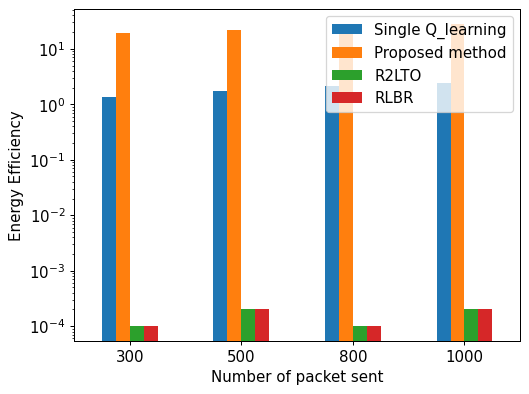

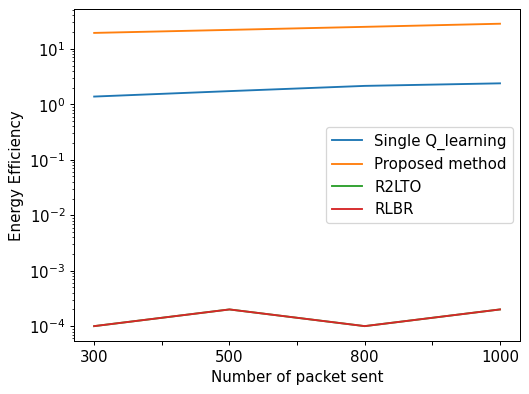

In [14]:

# Number of packet delivered for different number of packet sent
vaiable_packet_p = pd.DataFrame({'Single Q_learning':[268, 468,768,968], 'Proposed method':[266,466,766,966], 'R2LTO':[7,13,8,13], 'RLBR':[7,8,10,13]}, index = index_p)
#Average energy consumed for different number of packet sent
vaiable_packet_e = pd.DataFrame({'Single Q_learning':[193.69,269.7,357,405], 'Proposed method':[13.7,21.1,30.7,34], 'R2LTO':[52497,52773,53031,53051], 'RLBR':[52954,53026,53027,53067]}, index = index_p)
#  Energy efficiency for different number of packet sent
vaiable_packet_ee = pd.DataFrame({'Single Q_learning':[1.38,1.73,2.15,2.39], 'Proposed method':[19.4,22,24.95,28.4], 'R2LTO':[0.0001,0.0002,0.0001,0.0002], 'RLBR':[0.0001,0.0002,0.0001,0.0002]}, index = index_p)

ax = vaiable_packet_p.plot.bar(rot=0)
ax.set_xlabel("Number of packet sent")
ax.set_ylabel("Number of packet delivered")
ax.set_yscale('log')

ax_ = vaiable_packet_p.plot.line(rot=0)
ax_.set_xlabel("Number of packet sent")
ax_.set_ylabel("Number of packet delivered")
ax_.set_yscale('log')

ax2 = vaiable_packet_e.plot.bar(rot=0)
ax2.set_xlabel("Number of packet sent")
ax2.set_ylabel("Energy Consumption (mJ)")
ax2.set_yscale('log')

ax3 = vaiable_packet_ee.plot.bar(rot=0)
ax3.set_xlabel("Number of packet sent")
ax3.set_ylabel("Energy Efficiency")
ax3.set_yscale('log')

ax4 = vaiable_packet_ee.plot.line(rot=0)
ax4.set_xlabel("Number of packet sent")
ax4.set_ylabel("Energy Efficiency")
ax4.set_yscale('log')

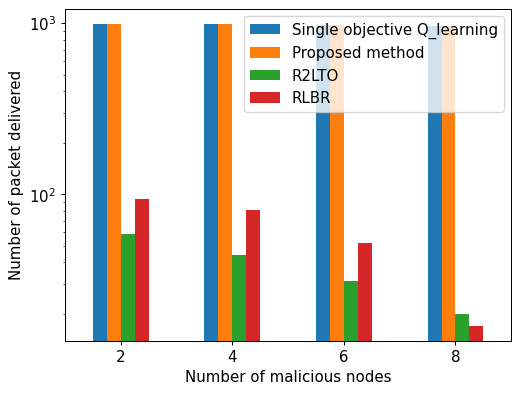

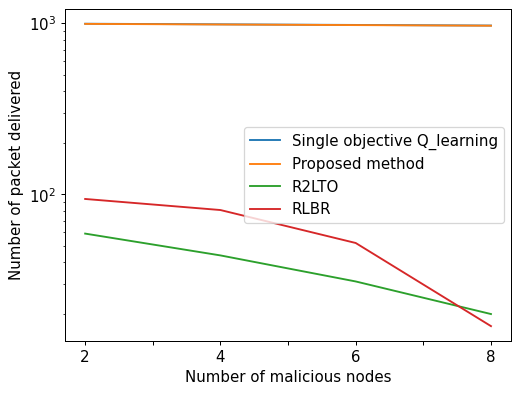

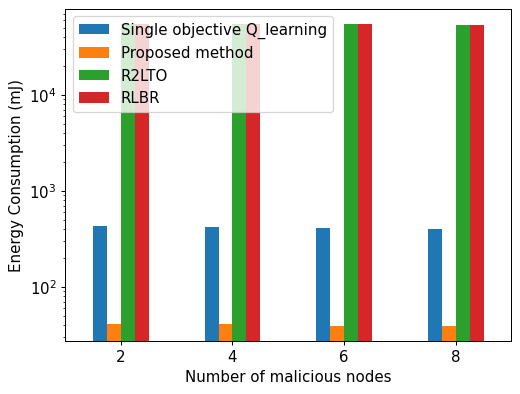

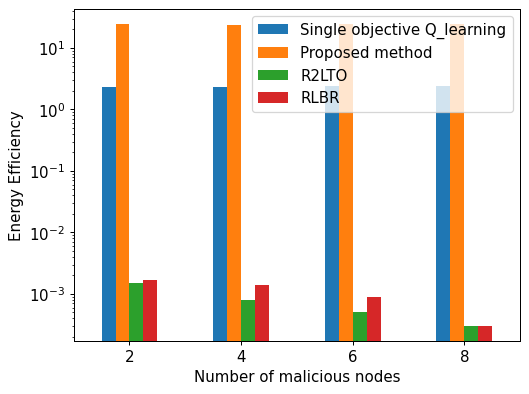

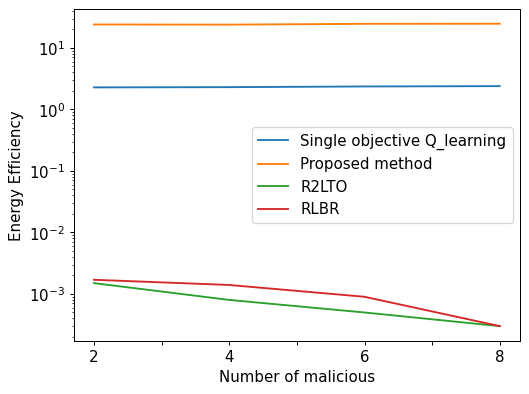

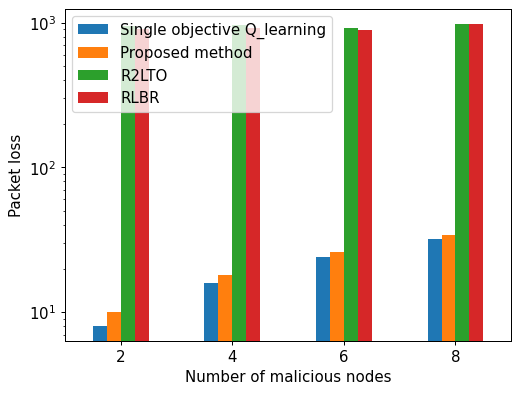

In [15]:
# Number of packet delivered for different number of malicious nodes
vaiable_malicious_p = pd.DataFrame({'Single objective Q_learning':[992, 984, 976, 968], 'Proposed method':[990, 982, 974, 966], 'R2LTO':[59, 44, 31, 20], 'RLBR':[94, 81, 52, 17]}, index = index_m)
#Average energy consumed for different number of malicious nodes
vaiable_malicious_e = pd.DataFrame({'Single objective Q_learning':[434, 421.7, 413.1, 404.4], 'Proposed method':[41.1, 41.1, 39.5, 39], 'R2LTO':[54810, 54843.7, 54515.4, 52991], 'RLBR':[54623, 54680.9, 54515.8, 53012]}, index = index_m)
#  Energy efficiency for different number of malicious nodes
vaiable_malicious_ee = pd.DataFrame({'Single objective Q_learning':[2.28, 2.3, 2.36, 2.39], 'Proposed method':[24, 23.89, 24.6, 24.7], 'R2LTO':[0.0015, 0.0008, 0.0005, 0.0003], 'RLBR':[0.0017, 0.0014, 0.0009, 0.0003]}, index = index_m)
# Packet lost for different number of malicious nodes
vaiable_malicious_pl = pd.DataFrame({'Single objective Q_learning':[8, 16, 24, 32], 'Proposed method':[10, 18, 26, 34], 'R2LTO':[941, 956, 919, 980], 'RLBR':[906, 919, 894, 983]}, index = index_m)

axis = vaiable_malicious_p.plot.bar(rot=0)
axis.set_xlabel("Number of malicious nodes")
axis.set_ylabel("Number of packet delivered")
axis.set_yscale('log')

axis_ = vaiable_malicious_p.plot.line(rot=0)
axis_.set_xlabel("Number of malicious nodes")
axis_.set_ylabel("Number of packet delivered")
axis_.set_yscale('log')

axis2 = vaiable_malicious_e.plot.bar(rot=0)
axis2.set_xlabel("Number of malicious nodes")
axis2.set_ylabel("Energy Consumption (mJ)")
axis2.set_yscale('log')

axis3 = vaiable_malicious_ee.plot.bar(rot=0)
axis3.set_xlabel("Number of malicious nodes")
axis3.set_ylabel("Energy Efficiency")
axis3.set_yscale('log')

axis4 = vaiable_malicious_ee.plot.line(rot=0)
axis4.set_xlabel("Number of malicious")
axis4.set_ylabel("Energy Efficiency")
axis4.set_yscale('log')

axis5 = vaiable_malicious_pl.plot.bar(rot=0)
axis5.set_xlabel("Number of malicious nodes")
axis5.set_ylabel("Packet loss")
axis5.set_yscale('log')

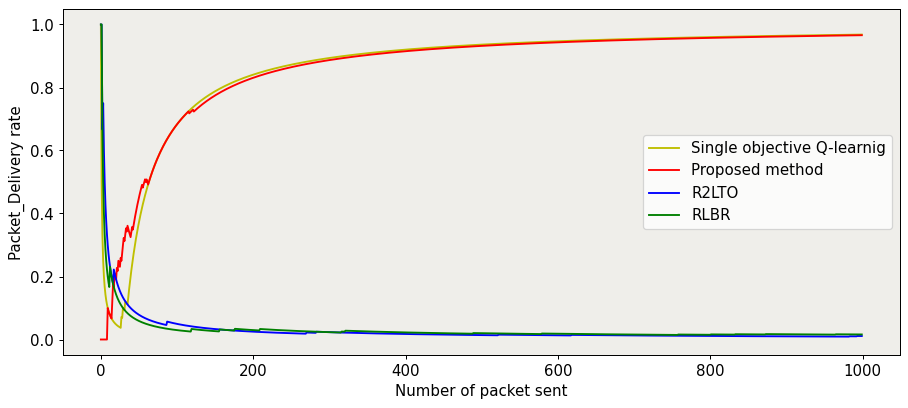

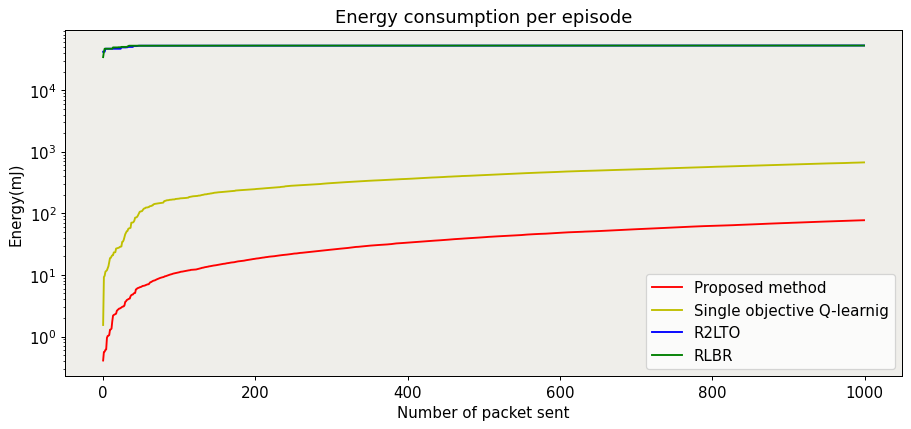

In [16]:
# Plot the result of two methods
x = range(len(delivery))
plt.figure(figsize=(12, 5))
plt.plot(x, packet_delivery2, color='y', label='Single objective Q-learnig')
plt.plot(x, packet_delivery, color='r', label='Proposed method')
plt.plot(x, delivery, color='b', label='R2LTO')
plt.plot(x, delivery2, color='g', label='RLBR')
plt.xlabel("Number of packet sent")
plt.ylabel("Packet_Delivery rate")
ax = plt.gca()
ax.set_facecolor('#efeeea')
plt.legend()
#plt.title("Comparing Epsilon")
plt.show()

x2 = range(len(t_energy))
plt.figure(figsize=(12, 5))
plt.plot(x2, t_energy, color='r', label='Proposed method')
plt.plot(x2, t_energy2, color='y', label='Single objective Q-learnig')
plt.plot(x2, energy, color='b', label='R2LTO')
plt.plot(x2, energy2, color='g', label='RLBR')
plt.xlabel("Number of packet sent")
plt.ylabel("Energy(mJ)")
plt.yscale('log')
ax = plt.gca()
ax.set_facecolor('#efeeea')
plt.legend()
plt.title("Energy consumption per episode")
plt.show()

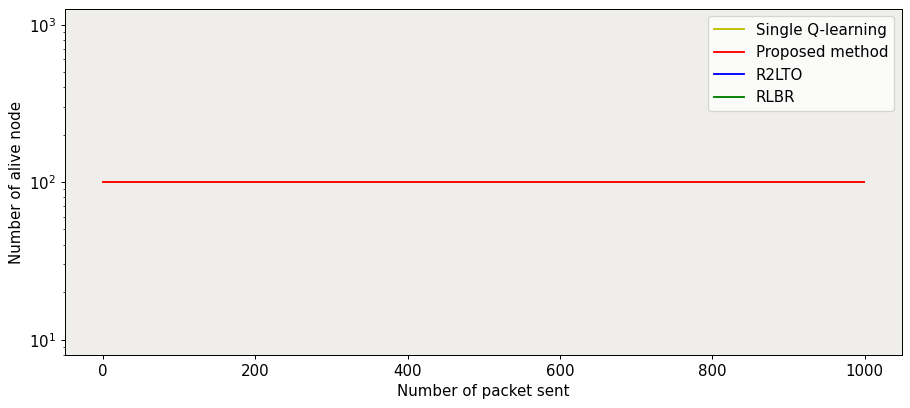

In [22]:
# Plot networks' lifetime

x = range(len(alive_node))
plt.figure(figsize=(12, 5))
plt.plot(x, alive_node2, color='y', label='Single Q-learning')
plt.plot(x, alive_node, color='r', label='Proposed method')
plt.plot(x, alive_node3, color='b', label='R2LTO')
plt.plot(x, alive_node4, color='g', label='RLBR')
plt.xlabel("Number of packet sent")
plt.ylabel("Number of alive node")
plt.yscale('log')
ax = plt.gca()
ax.set_facecolor('#efeeea')
plt.legend()
plt.show()